# Inference with clip based model of Surgical SAM

### Load libraries

In [1]:
import sys
import os.path as osp

sys.path.append("..")
from segment_anything import sam_model_registry
import torch
from torch.utils.data import DataLoader
from dataset import Endovis18Dataset, Endovis17Dataset
from model import Prototype_Prompt_Encoder, Learnable_Prototypes
from model_forward import model_forward_function
import argparse
from utils import (
    read_gt_endovis_masks,
    create_binary_masks,
    create_endovis_masks,
    eval_endovis,
)
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageOps
import os
import numpy as np
from importlib import reload
import re
## import clip_model_emb.py
import tools.clip_model_emb as cl_em_dt

seed = 42
random.seed(seed)
np.random.seed(seed)


c:\UNI Projekte\surgicalMDSAM\ENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parse arguments

In [2]:
print("======> Process Arguments")
parser = argparse.ArgumentParser()
parser.add_argument(
    "--dataset",
    type=str,
    default="endovis_2018",
    choices=["endovis_2018", "endovis_2017"],
    help="specify dataset",
)
parser.add_argument(
    "--fold",
    type=int,
    default=0,
    choices=[0, 1, 2, 3],
    help="specify fold number for endovis_2017 dataset",
)
# args = parser.parse_args()
args = parser.parse_args(
    [
        "--dataset",
        "endovis_2018",
        "--fold",
        "0",
    ]
)
print(args)

======> Process Arguments
Namespace(dataset='endovis_2018', fold=0)


### Set dataset

In [3]:

print("======> Set Parameters for Inference")
dataset_name = args.dataset
print(f"dataset_name: {dataset_name}")
fold = args.fold
thr = 0
#data_root_dir = f"../data/{dataset_name}"
data_root_dir = osp.join("..", "data", dataset_name)
# debug
print(f"Dataset: {dataset_name}")
print("data_root_dir: ", data_root_dir)

======> Set Parameters for Inference
dataset_name: endovis_2018
Dataset: endovis_2018
data_root_dir:  ..\data\endovis_2018


### Load Dataset classes

In [4]:
print("======> Load Dataset-Specific Parameters")
if "18" in dataset_name:
    num_tokens = 2
    dataset = Endovis18Dataset(data_root_dir=data_root_dir, mode="val", vit_mode="b")
    surgicalSAM_ckp = osp.join("..", "ckp", "sMDSAM", "model_ckp_lite.pth")

    gt_endovis_masks = read_gt_endovis_masks(data_root_dir=data_root_dir, mode="val")

elif "17" in dataset_name:
    num_tokens = 4
    dataset = Endovis17Dataset(
        data_root_dir=data_root_dir, mode="val", fold=fold, vit_mode="h", version=0
    )
    surgicalSAM_ckp = f"../ckp/surgical_sam/{dataset_name}/fold{fold}/model_ckp.pth"

    gt_endovis_masks = read_gt_endovis_masks(
        data_root_dir=data_root_dir, mode="val", fold=fold
    )

print("======> Load Model")
print("Dataset : ", dataset_name)

#pp.pprint(dataset.mask_list)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

======> Load Dataset-Specific Parameters
======> Load Model
Dataset :  endovis_2018


### Load sam checkpoint

In [5]:
print("======> Load SAM")
#sam_checkpoint = "../ckp/sam/sam_vit_h_4b8939.pth"
sam_checkpoint = "../ckp/lite_medsam/lite_medsam.pth"

print(f"checkpoint: {sam_checkpoint}")
# try loading the model
try:
    model_type = "vit_h_no_image_encoder"
    sam_prompt_encoder, sam_decoder = sam_model_registry[model_type](
        checkpoint=sam_checkpoint
    )
except KeyError:
    raise ValueError(f"Unknown model type: {model_type}")

sam_prompt_encoder.cuda()
sam_decoder.cuda()


======> Load SAM
checkpoint: ../ckp/lite_medsam/lite_medsam.pth


MaskDecoder(
  (transformer): TwoWayTransformer(
    (layers): ModuleList(
      (0-1): 2 x TwoWayAttentionBlock(
        (self_attn): Attention(
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (cross_attn_token_to_image): Attention(
          (q_proj): Linear(in_features=256, out_features=128, bias=True)
          (k_proj): Linear(in_features=256, out_features=128, bias=True)
          (v_proj): Linear(in_features=256, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=256, bias=True)
        )
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_fea

### Set Prototypes and Promt Encoder

In [6]:
reload(cl_em_dt)

instrument_details = [
                "Instrument: Bipolar Forceps",
                "Instrument: Prograsp Forceps",
                "Instrument: Large Needle Driver",
                "Instrument: Monopolar Curved Scissors",
                "Instrument: Ultrasound Probe",
                "Instrument: Suction Instrument",
                "Instrument: Clip Applier",
            ]


# clip_emb = clip_model_emb.get_emb(output_dim=256)
feat_dim = 256

print("======> Load Prototypes and Prototype-based Prompt Encoder")
learnable_prototypes_model = Learnable_Prototypes(
    num_classes=7, feat_dim=feat_dim#, clip_embeddings=clip_emb
).cuda()


print("======> Load Prototypes and Prototype-based Prompt Encoder")
protoype_prompt_encoder = Prototype_Prompt_Encoder(
    feat_dim=256,
    hidden_dim_dense=128,
    hidden_dim_sparse=128,
    size=64,
    num_tokens=num_tokens,
    num_cls=7,
).cuda()

======> Load Prototypes and Prototype-based Prompt Encoder
======> Load Prototypes and Prototype-based Prompt Encoder


In [7]:

# load the weight for prototype-based prompt encoder, mask decoder, and prototypes
checkpoint = torch.load(surgicalSAM_ckp)
protoype_prompt_encoder.load_state_dict(
    checkpoint["prototype_prompt_encoder_state_dict"]
)
sam_decoder.load_state_dict(checkpoint["sam_decoder_state_dict"])
learnable_prototypes_model.load_state_dict(checkpoint["prototypes_state_dict"])

# set requires_grad to False to the whole model
for name, param in sam_prompt_encoder.named_parameters():
    param.requires_grad = False
for name, param in sam_decoder.named_parameters():
    param.requires_grad = False
for name, param in protoype_prompt_encoder.named_parameters():
    param.requires_grad = False
for name, param in learnable_prototypes_model.named_parameters():
    param.requires_grad = False

## Inference

In [8]:
print("======> Start Inference")
binary_masks = dict()
protoype_prompt_encoder.eval()
sam_decoder.eval()
learnable_prototypes_model.eval()

with torch.no_grad():
    prototypes = learnable_prototypes_model()

    for sam_feats, mask_names, cls_ids, _, _ in dataloader:

        sam_feats = sam_feats.cuda()
        cls_ids = cls_ids.cuda()

        preds, preds_quality = model_forward_function(
            protoype_prompt_encoder,
            sam_prompt_encoder,
            sam_decoder,
            sam_feats,
            prototypes,
            cls_ids,
        )

        binary_masks = create_binary_masks(
            binary_masks, preds, preds_quality, mask_names, thr, normalize_masks=False
        )
# for seq_name in binary_masks.keys():
#     for frame_name in binary_masks[seq_name].keys():
#         for mask_dict in binary_masks[seq_name][frame_name]:
#             mask = mask_dict['mask']
#             print(f"Sequence: {seq_name}, Frame: {frame_name}, Mask max: {mask.max()}, Mask min: {mask.min()}")


endovis_masks = create_endovis_masks(binary_masks, 1024, 1280, normalize_masks=False)


======> Start Inference


In [9]:
print(endovis_masks.keys())

dict_keys(['seq9\\00094.png', 'seq9\\00120.png', 'seq9\\00065.png', 'seq9\\00110.png', 'seq9\\00036.png', 'seq9\\00027.png', 'seq9\\00146.png', 'seq9\\00093.png', 'seq9\\00141.png', 'seq9\\00024.png', 'seq9\\00134.png', 'seq9\\00127.png', 'seq9\\00090.png', 'seq9\\00017.png', 'seq9\\00003.png', 'seq9\\00088.png', 'seq9\\00104.png', 'seq9\\00009.png', 'seq9\\00112.png', 'seq9\\00030.png', 'seq9\\00079.png', 'seq9\\00145.png', 'seq9\\00097.png', 'seq9\\00038.png', 'seq9\\00148.png', 'seq9\\00013.png', 'seq9\\00051.png', 'seq9\\00108.png', 'seq9\\00046.png', 'seq9\\00012.png', 'seq9\\00031.png', 'seq9\\00032.png', 'seq9\\00018.png', 'seq9\\00082.png', 'seq9\\00102.png', 'seq9\\00099.png', 'seq9\\00107.png', 'seq9\\00135.png', 'seq9\\00138.png', 'seq9\\00109.png', 'seq9\\00004.png', 'seq9\\00039.png', 'seq9\\00098.png', 'seq9\\00040.png', 'seq9\\00133.png', 'seq9\\00067.png', 'seq9\\00008.png', 'seq9\\00007.png', 'seq9\\00060.png', 'seq9\\00020.png', 'seq9\\00122.png', 'seq9\\00066.png', '

Mask seq9\00064.png unique pixel values: [0 4]
Mask seq9\00013.png unique pixel values: [0 1 4]
Mask seq15\00053.png unique pixel values: [0 1 4]
Mask seq15\00143.png unique pixel values: [0 1 4]
Mask seq15\00072.png unique pixel values: [0 1 4]
Mask seq15\00083.png unique pixel values: [0 4]
Mask seq9\00011.png unique pixel values: [0 1 4]
Mask seq2\00123.png unique pixel values: [0 2]
Mask seq9\00105.png unique pixel values: [0 4]
Mask seq5\00108.png unique pixel values: [0 1 4 6]


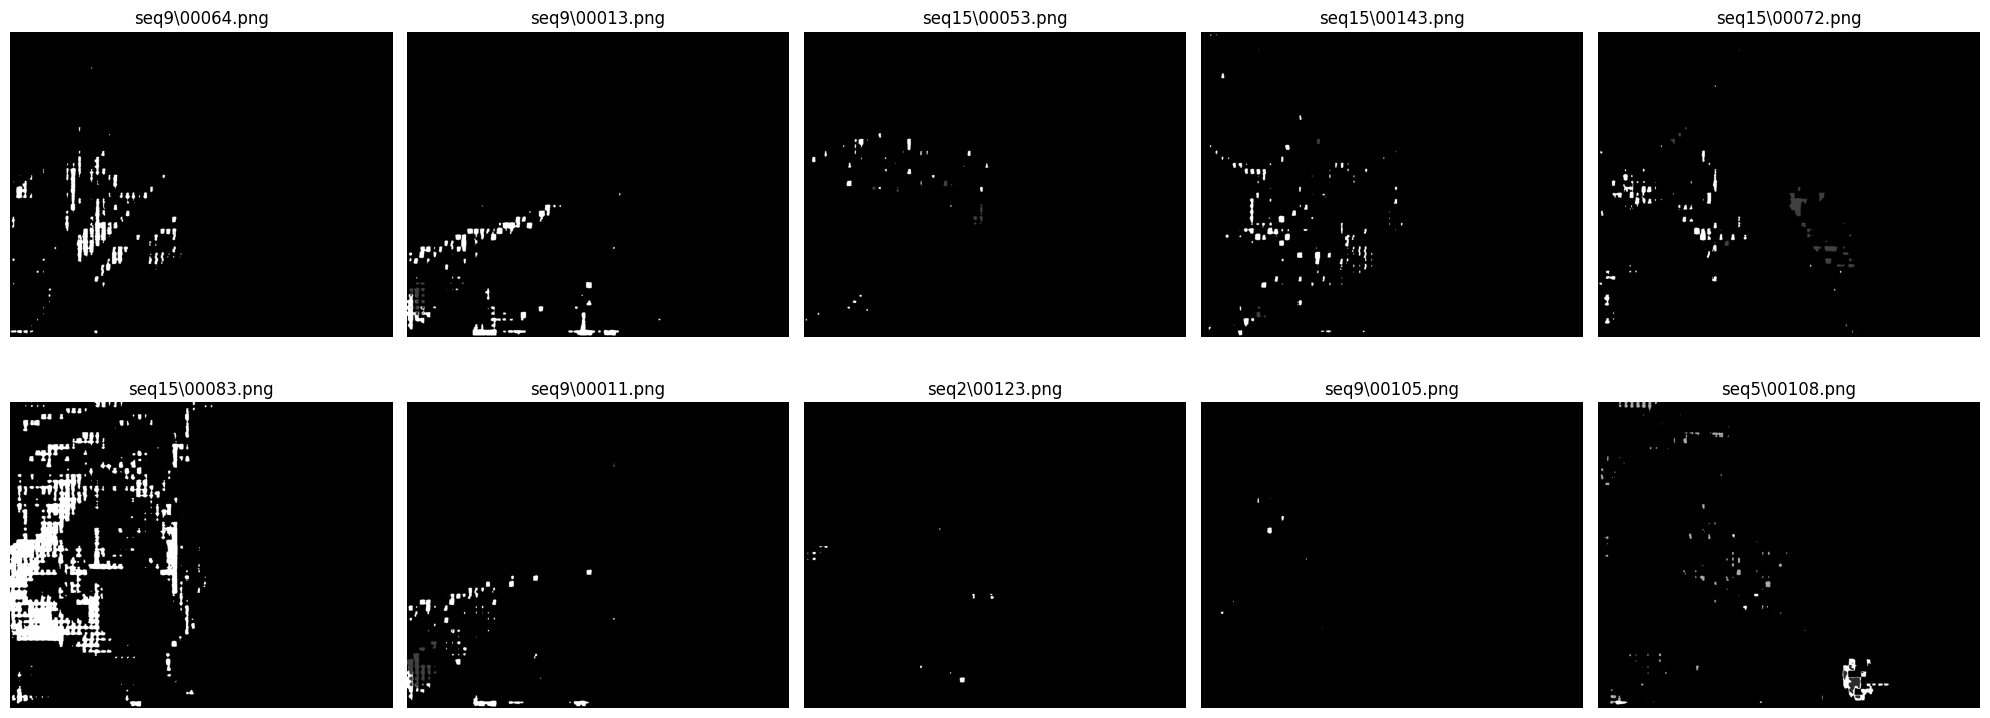

In [10]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Function to plot random masks and print their pixel values
def plot_and_inspect_masks(masks_dict, num_masks=10, normalize=False):
    keys = list(masks_dict.keys())
    random_keys = random.sample(keys, min(num_masks, len(keys)))

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    for ax, key in zip(axes.flatten(), random_keys):
        mask = masks_dict[key]
        if normalize:
            mask = (mask > 0).astype(int)  # Normalize to binary mask


        ax.set_title(key)
        ax.axis('off')

        # Print some pixel values for inspection
        unique_values = np.unique(mask)
        ax.imshow(mask, cmap='gray')
        print(f"Mask {key} unique pixel values: {unique_values}")

    plt.tight_layout()
    plt.show()

# Assuming endovis_masks is a dictionary with mask names as keys and mask arrays as values
# Plot 10 random masks and print their unique pixel values
plot_and_inspect_masks(endovis_masks, num_masks=10, normalize=False)


Processing seq9\00064.png: unique pixel values [0 4]
Processing seq9\00013.png: unique pixel values [0 1 4]
Processing seq15\00053.png: unique pixel values [0 1 4]
Processing seq15\00143.png: unique pixel values [0 1 4]
Processing seq15\00072.png: unique pixel values [0 1 4]
Processing seq15\00083.png: unique pixel values [0 4]
Processing seq9\00011.png: unique pixel values [0 1 4]
Processing seq2\00123.png: unique pixel values [0 2]
Processing seq9\00105.png: unique pixel values [0 4]
Processing seq5\00108.png: unique pixel values [0 1 4 6]


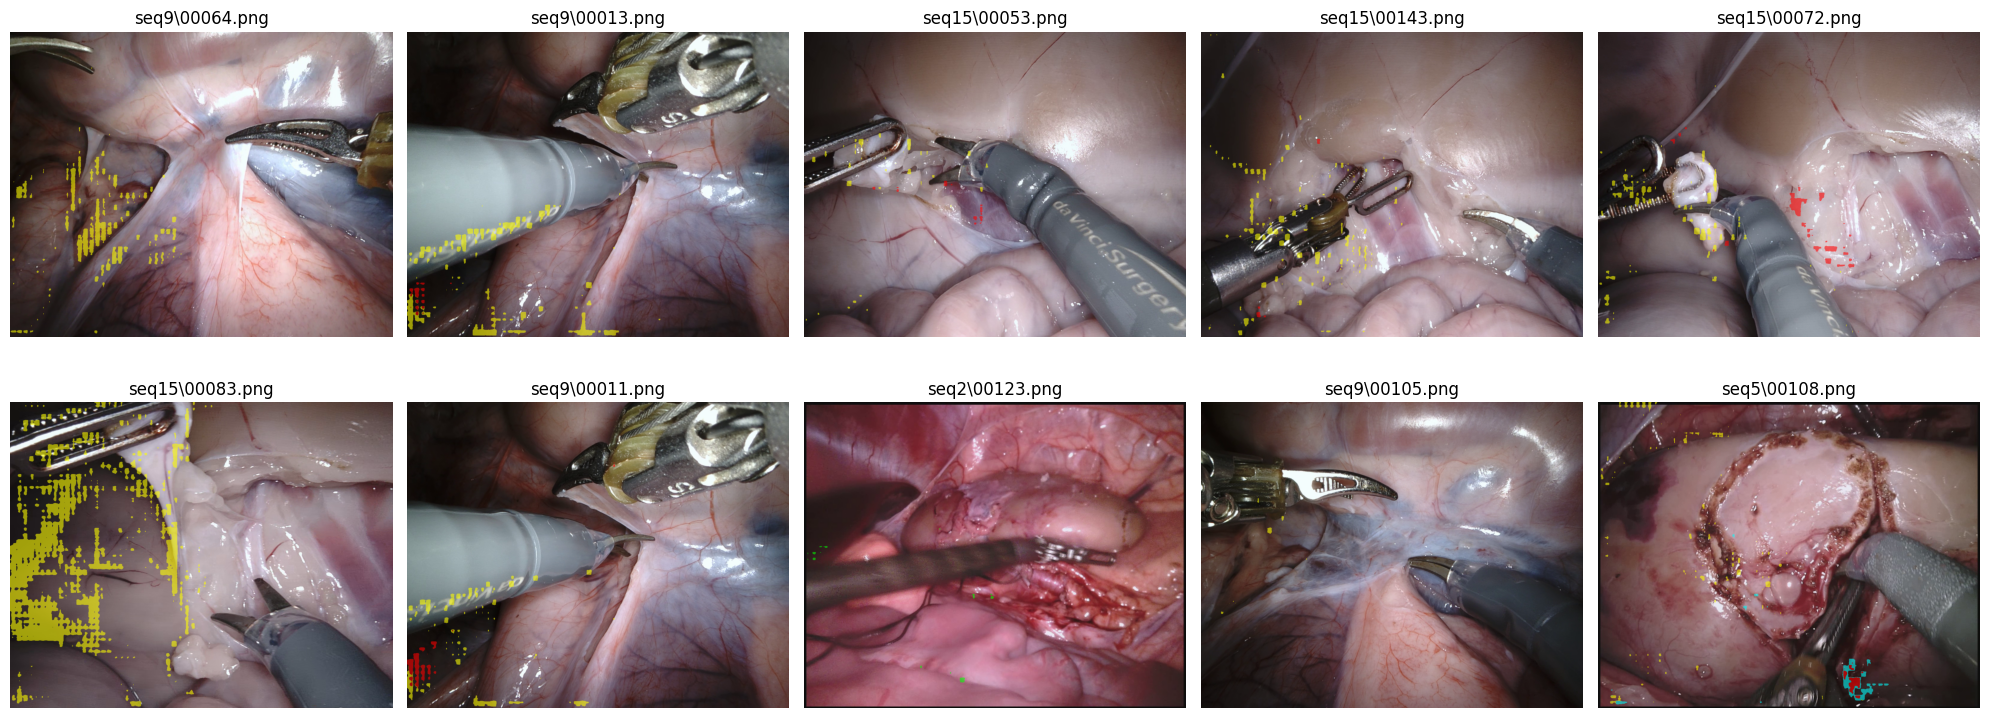

In [11]:
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageDraw
import os
import numpy as np

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

# Color map for classes
CLASS_COLOR_MAP = {
    1: (255, 0, 0, 150),   # Red with alpha
    2: (0, 255, 0, 150),   # Green with alpha
    3: (0, 0, 255, 150),   # Blue with alpha
    4: (255, 255, 0, 150), # Yellow with alpha
    5: (255, 0, 255, 150), # Magenta with alpha
    6: (0, 255, 255, 150), # Cyan with alpha
    7: (128, 0, 128, 150)  # Purple with alpha
}

def apply_class_colors(mask, class_color_map):
    h, w = mask.shape
    colored_mask = np.zeros((h, w, 4), dtype=np.uint8)  # RGBA

    for class_id, color in class_color_map.items():
        indices = mask == class_id
        colored_mask[indices] = color

    return colored_mask

def plot_random_masks_with_overlay(masks_dict, image_dir, num_masks=10):
    keys = list(masks_dict.keys())
    random_keys = random.sample(keys, min(num_masks, len(keys)))

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    for ax, key in zip(axes.flatten(), random_keys):
        mask = masks_dict[key]
        unique_values = np.unique(mask)
        print(f"Processing {key}: unique pixel values {unique_values}")

        seq_name = os.path.dirname(key)
        image_name = os.path.basename(key)
        image_path = os.path.join(image_dir, seq_name, image_name)
        
        if not os.path.exists(image_path):
            print(f"Image path does not exist: {image_path}")
            continue
        
        original_image = Image.open(image_path).convert("RGBA")
        original_image_np = np.array(original_image)

        overlay_image_np = apply_class_colors(mask, CLASS_COLOR_MAP)

        # Combine original image and overlay
        combined_image_np = Image.alpha_composite(original_image, Image.fromarray(overlay_image_np))

        # Plot the result
        ax.imshow(combined_image_np)
        ax.set_title(key)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
image_dir = os.path.join(data_root_dir, "val", "images")  # Adjust 'data_root_dir' as necessary
plot_random_masks_with_overlay(endovis_masks, image_dir, num_masks=10)


In [12]:
endovis_results = eval_endovis(endovis_masks, gt_endovis_masks)

print(endovis_results)

KeyboardInterrupt: 

With instruments: 
======> Start Inference
{'challengIoU': 80.329, 'IoU': 80.329, 'mcIoU': 58.868, 'mIoU': 77.946, 'cIoU_per_class': [83.656, 65.627, 58.742, 88.559, 21.224, 54.476, 39.792]}







Regular:
